In [1]:
import os
from tempfile import tempdir
from time import time
from unittest.mock import NonCallableMagicMock
import pandas as pd
import numpy as np
import warnings
import math
import re
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

import seaborn as sns
warnings.filterwarnings("ignore")

import sys
sys.path.append("./")

from pathlib import Path

import tqdm
import importlib

import matplotlib.pyplot as plt
# from PySide2.QtWidgets import QFileDialog, QApplication
# from PySide2.QtCore import Qt
from copy import copy 

import pandas as pd

from corems.mass_spectra.input import rawFileReader
from corems.molecular_id.factory.classification import HeteroatomsClassification, Labels
from corems.molecular_id.search.priorityAssignment import OxygenPriorityAssignment
from corems.molecular_id.search.molecularFormulaSearch import SearchMolecularFormulas
from corems.encapsulation.factory.parameters import MSParameters
from corems.encapsulation.constant import Atoms
from corems.mass_spectrum.calc.Calibration import MzDomainCalibration

import corems.lc_icpms_ftms.calc.lc_icrms_qc_assign as icrms
import corems.lc_icpms_ftms.calc.lc_icrms_helpers as lcmsfns
import corems.lc_icpms_ftms.calc.align_icpms_esi_fns as algnfns

import importlib

from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

#drive_dir = '/Users/christiandewey/Library/CloudStorage/GoogleDrive-christian.w.dewey@gmail.com/My Drive/manuscripts/2023_Dewey-Boiteau-etal_mz-windowing/' 
drive_dir = '/home/dewey/Rawfiles/spring-env/pos/test/'
#svdir = drive_dir + 'figures/'
rawfiledir = '/home/dewey/Rawfiles/spring-env/pos/test/'


In [2]:
class Assignments:
    ''' 1 Mar 23
        Author: Christian Dewey
        
        intended for m/z windowing project
        works for 100 and 1000 m/z windows 
    '''
    def __init__(self, processed_assignments, mzrange, dataset_name):
        
        self._data_df = processed_assignments

        self.mzrange = mzrange

        self.dataset_name = dataset_name
        
        self.subsetByWindow()

        self.subsetAssignedUnique()

        self.combine()

        self.determineOverlap()


    def subsetByWindow(self):
        # create subsets of assignments based m/z window
        list100mz = []
        listfullzmz = [] 
        for mzwindow in self._data_df['Window Size (m/z)'].unique():

            r_df = self._data_df[self._data_df['Window Size (m/z)'] == mzwindow]

            if (mzwindow =='100'):
                list100mz.append(r_df) 

            elif (mzwindow =='1000'):
                listfullzmz.append(r_df) 

        self.mz100 = pd.concat(list100mz,ignore_index=True)
        self.mzfull = pd.concat(listfullzmz,ignore_index=True)

        self.mzfull_range = self.mzfull[(self.mzfull['m/z']>=self.mzrange[0])]
        self.mzfull_range = self.mzfull_range[(self.mzfull_range['m/z']<=self.mzrange[1])]

    def subsetAssignedUnique(self):
        # create subsets of assigned features and unique features 

        self.assigned_100mz = self.mz100[~self.mz100['Molecular Formula'].isnull()]
        self.assigned_fullmz = self.mzfull[~self.mzfull['Molecular Formula'].isnull()]  

        self.unique_100mz = lcmsfns.getUniqueFeatures(self.assigned_100mz)  ######
        self.unique_fullmz = lcmsfns.getUniqueFeatures(self.assigned_fullmz) #####

        self.assigned_fullmz_range = self.assigned_fullmz[(self.assigned_fullmz['m/z']>=self.mzrange[0])]
        self.assigned_fullmz_range = self.assigned_fullmz_range[(self.assigned_fullmz_range['m/z']<=self.mzrange[1])]
        self.unique_fullmz_range = lcmsfns.getUniqueFeatures(self.assigned_fullmz_range) #####




    

        print('\n100 m/z window (narrow):')
        print('%s features total\n%s assigned (%.1f%%)\n%s unique' %(np.shape(self.mz100)[0],  np.shape(self.assigned_100mz)[0], 
                                                                     (np.shape(self.assigned_100mz)[0] / np.shape(self.mz100)[0] * 100), 
                                                                     np.shape(self.unique_100mz)[0]))
        
        print('\n100-1100 m/z window, between %s-%s m/z:' %(self.mzrange[0],self.mzrange[1]))
        print('%s features total\n%s assigned (%.1f%%)\n%s unique' %(np.shape(self.mzfull_range)[0],np.shape(self.assigned_fullmz_range)[0],  
                                                                     np.shape(self.assigned_fullmz_range)[0] / np.shape(self.mzfull_range)[0] * 100, 
                                                                     len(self.unique_fullmz_range)))
        
        print('\n100-1100 m/z window (full):')
        print('%s features total\n%s assigned (%.1f%%)\n%s unique' %(np.shape(self.mzfull)[0],np.shape(self.assigned_fullmz)[0],  
                                                                     (np.shape(self.assigned_fullmz)[0] / np.shape(self.mzfull)[0] * 100),
                                                                     np.shape(self.unique_fullmz)[0]))

    def combine(self):
        # get combo unique 
        self.combo_assigned = pd.concat([self.assigned_100mz, self.assigned_fullmz_range], ignore_index=True)
        self.combo_unique =  pd.concat([self.unique_100mz, self.unique_fullmz_range], ignore_index=True)
        mzfull_range = self.mzfull[(self.mzfull['Calibrated m/z']>=self.mzrange[0]) & (self.mzfull['Calibrated m/z']<=self.mzrange[1])]
        self.combo_all = pd.concat([self.mz100, mzfull_range], ignore_index=True)

        print('\nOverall summary:\n%s features total' %len(self.combo_all))
        print('%s assigned features' %len(self.combo_assigned))
        print('%s unique features' %len(self.combo_unique))
   

    def determineOverlap(self):
        dd = self.combo_unique

        self.fullscan =  dd[dd['Window Size (m/z)'] == '1000']
        self.narrowscan = dd[dd['Window Size (m/z)'] == '100']

        print(len(self.fullscan),  len(self.narrowscan))

        self.narrowscan['mf_t'] = self.narrowscan['Molecular Formula'] + '-time_'+self.narrowscan['Time'].map(str)    
        self.fullscan['mf_t'] = self.fullscan['Molecular Formula'] + '-time_'+ self.fullscan['Time'].map(str)   
       
        shared_mf_t = list(set(list(self.narrowscan['mf_t'])) & set(list(self.fullscan['mf_t'])))
        onlyfull_mf_t = list(set(list(self.fullscan['mf_t'])) ^ set(shared_mf_t))
        onlynarrow_mf_t  = list(set(list(self.narrowscan['mf_t'])) ^ set(shared_mf_t))

        print('\n%s shared features' %len(shared_mf_t))
        print('%s features only in full window' %len(onlyfull_mf_t))
        print('%s features only in narrow window' %len(onlynarrow_mf_t))

        self.features_in_narrow_only = self.narrowscan[(self.narrowscan['mf_t'].isin(onlynarrow_mf_t))]
        self.features_in_full_only = self.fullscan[(self.fullscan['mf_t'].isin(onlyfull_mf_t))]

        dd2 = pd.concat([self.narrowscan,self.fullscan])
        self.features_in_both = dd2[(dd2['mf_t'].isin(shared_mf_t))]
        
        '''self.features_in_both=self.features_in_both.sort_values(by=['m/z Error (ppm)'],ascending=True)
        self.features_in_both=self.features_in_both.drop_duplicates(subset=['mf_t'])

        print(len(self.features_in_both))'''
        self.features_not_in_full = dd2[(~dd2['mf_t'].isin(shared_mf_t))]

        self.features_in_narrow_only['FeatureIn'] = '100'
        self.features_in_full_only['FeatureIn'] ='1000'
        self.features_in_both['FeatureIn'] = '100,1000'



        '''shared_mf = list(set(list(self.narrowscan['Molecular Formula'])) & set(list(self.fullscan['Molecular Formula'])))
        onlyfull_mf = list(set(list(self.fullscan['Molecular Formula'])) ^ set(shared_mf))
        onlynarrow_mf  = list(set(list(self.narrowscan['Molecular Formula'])) ^ set(shared_mf))

        print('\n%s m.f in narrow window' %len(set(self.narrowscan['Molecular Formula'])))
        print('%s m.f in full window' %len(set(self.fullscan['Molecular Formula'])))
        print('%s shared m.f.' %len(shared_mf))
        print('%s m.f. only in full window' %len(onlyfull_mf))
        print('%s m.f. only in narrow window' %len(onlynarrow_mf))

        self.mf_in_narrow_only = self.narrowscan[(self.narrowscan['Molecular Formula'].isin(onlynarrow_mf))]
        self.mf_in_full_only = self.fullscan[(self.fullscan['Molecular Formula'].isin(onlyfull_mf))]

        dd3 = pd.concat([self.narrowscan,self.fullscan])
        self.mf_in_both = dd3[(dd3['Molecular Formula'].isin(shared_mf))]
        self.mf_not_in_full = dd3[(~dd3['Molecular Formula'].isin(shared_mf))]

        self.mf_in_narrow_only['MF_In'] = '100'
        self.mf_in_full_only['MF_In'] ='1000'
        self.mf_in_both['MF_In'] = '100,1000'''



In [3]:

def postAssignProcess(heter):

    ##add 'Window Size (m/z)', 'm/z window', 'Rep', 'mol_class' columns

    global results

    results = lcmsfns.add_mzwindow_col(results)                 # adds 'Window Size (m/z)' and 'm/z window' columns
    results = lcmsfns.addRepCol(results)                        # adds 'Rep' column
    molclasses = lcmsfns.get_mol_class(heter)                   # creates list of mol_classes based on heteroatom list
    results = lcmsfns.assign_mol_class(results,molclasses)      # adds 'mol_class' column 


In [4]:
#### SPRING-ENV
#### LOAD PROCESSED DATA SET FOR FIGURES 

importlib.reload(lcmsfns)

data_dir = drive_dir 

heter = ['N', 'Na', 'S', 'P', 'K', 'Cu','Fe'] 

results = pd.read_csv(data_dir+'230328_spring-env_pos.csv')

postAssignProcess(heter)

results.to_csv(data_dir+'p230328_spring-env_pos.csv')


data_df = pd.read_csv(data_dir+'p230328_spring-env_pos.csv'  ) 

data_df['Window Size (m/z)'] = data_df['Window Size (m/z)'].map(str)

print(data_df['Window Size (m/z)'].unique())
spring_asgn = Assignments(data_df, mzrange=[400,600], dataset_name='spring-env')


20221103_LBA_Boiteau_Zorbax3p5_spring_fullmz.raw
20221103_LBA_Boiteau_Zorbax3p5_spring_400_600.raw
20221103_LBA_Boiteau_Zorbax3p5_spring_500_600.raw
20221103_LBA_Boiteau_Zorbax3p5_spring_400_500.raw
[1]

time: 10
unassigned:  182
assigned:  8502
	CHO: 1744
	CHON: 3543
	CHONNa: 1
	CHONS: 145
	CHONP: 185
	CHONK: 6
	CHONCu: 0
	CHONFe: 9
	CHONa: 1
	CHONaS: 0
	CHONaP: 0
	CHONaK: 6
	CHONaCu: 90
	CHONaFe: 0
	CHOS: 96
	CHOSP: 26
	CHOSK: 42
	CHOSCu: 0
	CHOSFe: 29
	CHOP: 1400
	CHOPK: 0
	CHOPCu: 2
	CHOPFe: 6
	CHOK: 1
	CHOKCu: 0
	CHOKFe: 0
	CHOCu: 2
	CHOCuFe: 0
	CHOFe: 0
	CHONNaS: 14
	CHONNaP: 3
	CHONNaK: 1
	CHONNaCu: 25
	CHONNaFe: 1
	CHONSP: 60
	CHONSK: 4
	CHONSCu: 1
	CHONSFe: 17
	CHONPK: 81
	CHONPCu: 16
	CHONPFe: 8
	CHONKCu: 1
	CHONKFe: 0
	CHONCuFe: 0
	CHONNaSP: 6
	CHONNaSK: 685
	CHONNaSCu: 1
	CHONNaSFe: 1
	CHONNaPK: 4
	CHONNaPCu: 1
	CHONNaPFe: 88
	CHONNaKCu: 0
	CHONNaKFe: 9
	CHONNaCuFe: 0
	CHONNaSPK: 14
	CHONNaSPCu: 0
	CHONNaSPFe: 9
	CHONNaSKCu: 0
	CHONNaSKFe: 0
	CHONNaSCuFe: 0
	CHONNaSPKCu: 5


3238
1925
2608
599.2487702409956


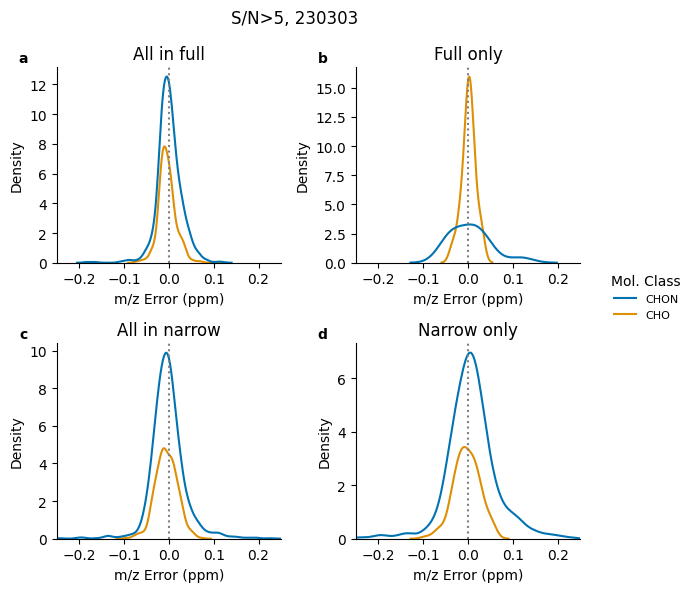

In [5]:
## PLOT CHO, CHON error for both windows

data_df = spring_asgn

df_both = data_df.features_in_both
df_full = pd.concat([data_df.features_in_full_only, df_both[df_both['Window Size (m/z)'] == '1000']])
df_narrow = pd.concat([data_df.features_in_narrow_only, df_both[df_both['Window Size (m/z)'] == '100']])

print(len(df_both))
print(len(df_full))
print(len(df_narrow))

print(max(df_full['m/z']))
dd = pd.concat([df_both, df_full,df_narrow])

molclass = [ 'CHON','CHO']

xmin = -0.25
xmax = 0.25

hc = 'mol_class'

fig, ((ax3,ax4),(ax5,ax6)) = plt.subplots(2, 2, figsize = (6,6))

ax = ax3
df = df_full[df_full['mol_class'].isin(molclass)]
ax = sns.kdeplot(data=df,x='m/z Error (ppm)',hue=hc, ax=ax, legend = False, palette = sns.color_palette('colorblind'))
ax.axvline(0, color = 'gray', linestyle = ':')
ax.set_xlim(xmin,xmax)
ax.set_title('All in full')

ax = ax5
df = df_narrow[df_narrow['mol_class'].isin(molclass)]
ax = sns.kdeplot(data=df,x='m/z Error (ppm)',hue=hc, ax=ax, legend  = False, palette = sns.color_palette('colorblind'))
ax.axvline(0, color = 'gray', linestyle = ':')
ax.set_xlim(xmin,xmax)
ax.set_xlim(xmin,xmax)
ax.set_title('All in narrow')



ax = ax4
df = data_df.features_in_full_only[data_df.features_in_full_only['mol_class'].isin(molclass)]
ax = sns.kdeplot(data=df,x='m/z Error (ppm)',hue=hc, ax=ax, legend = False, palette = sns.color_palette('colorblind'))
ax.axvline(0, color = 'gray', linestyle = ':')
ax.set_xlim(xmin,xmax)
ax.set_title('Full only')

ax = ax6
df = data_df.features_in_narrow_only[data_df.features_in_narrow_only['mol_class'].isin(molclass)]
ax = sns.kdeplot(data=df,x='m/z Error (ppm)',hue=hc, ax=ax, palette = sns.color_palette('colorblind'))
ax.axvline(0, color = 'gray', linestyle = ':')
ax.set_xlim(xmin,xmax)
ax.set_title('Narrow only')

lbls_art = []
lbls = ['a','b','c','d','e']
axs = [ax3,ax4,ax5,ax6]
for lbl, ax in zip(lbls,axs):
    l = ax.text(-0.15, 1.05,lbl,
        horizontalalignment='center',
        verticalalignment='center',
        transform = ax.transAxes, fontweight='bold', fontsize = 10)
    lbls_art.append(l)


legend = ax6.get_legend()
handles = legend.legendHandles
legend.remove()
labels = molclass
leg = fig.legend(handles, labels, bbox_to_anchor=(1.02, 0.5), loc='center left',frameon=False, borderaxespad=0, title = 'Mol. Class', prop={'size': 8})


sttl = fig.suptitle('S/N>5, 230303')

fig.tight_layout()
#plt.show()
sns.despine()
lbla, lblb, lblc, lbld= lbls_art
#plt.savefig(data_dir + 'mz_error_CHO_CHON_SN>5_spring-env.pdf', bbox_extra_artists=(leg,lbla,lblb,lblc,lbld,sttl), bbox_inches='tight')
plt.show()

3238
1925
989
599.2487702409956


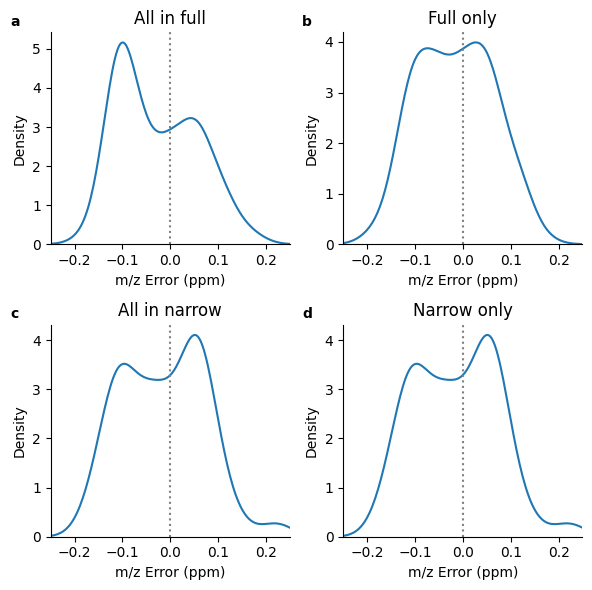

In [12]:
## PLOT CHOP, CHOS, CHONa, CHOK error for both windows

data_df = spring_asgn

df_both = data_df.features_in_both
df_full = pd.concat([data_df.features_in_full_only, df_both[df_both['Window Size (m/z)'] == '1000']])
df_narrow = pd.concat([data_df.features_in_narrow_only, df_both[df_both['Window Size (m/z)'] == '200']])

print(len(df_both))
print(len(df_full))
print(len(df_narrow))

print(max(df_full['m/z']))
dd = pd.concat([df_both, df_full,df_narrow])

hetero = 'Na'

xmin = -0.25
xmax = 0.25

hc = 'mol_class'

fig, ((ax3,ax4),(ax5,ax6)) = plt.subplots(2, 2, figsize = (6,6))

ax = ax3
df = df_full[df_full[hetero]>0]
ax = sns.kdeplot(data=df,x='m/z Error (ppm)', ax=ax, legend = False, palette = sns.color_palette('colorblind'))
ax.axvline(0, color = 'gray', linestyle = ':')
ax.set_xlim(xmin,xmax)
ax.set_title('All in full')

ax = ax5
df = df_narrow[df_narrow[hetero]> 0]
ax = sns.kdeplot(data=df,x='m/z Error (ppm)', ax=ax, legend  = False, palette = sns.color_palette('colorblind'))
ax.axvline(0, color = 'gray', linestyle = ':')
ax.set_xlim(xmin,xmax)
ax.set_xlim(xmin,xmax)
ax.set_title('All in narrow')



ax = ax4
df = data_df.features_in_full_only[data_df.features_in_full_only[hetero] > 0]
ax = sns.kdeplot(data=df,x='m/z Error (ppm)', ax=ax, legend = False, palette = sns.color_palette('colorblind'))
ax.axvline(0, color = 'gray', linestyle = ':')
ax.set_xlim(xmin,xmax)
ax.set_title('Full only')

ax = ax6
df = data_df.features_in_narrow_only[data_df.features_in_narrow_only[hetero]>0]
ax = sns.kdeplot(data=df,x='m/z Error (ppm)', ax=ax, legend = False, palette = sns.color_palette('colorblind'))
ax.axvline(0, color = 'gray', linestyle = ':')
ax.set_xlim(xmin,xmax)
ax.set_title('Narrow only')

lbls_art = []
lbls = ['a','b','c','d','e']
axs = [ax3,ax4,ax5,ax6]
for lbl, ax in zip(lbls,axs):
    l = ax.text(-0.15, 1.05,lbl,
        horizontalalignment='center',
        verticalalignment='center',
        transform = ax.transAxes, fontweight='bold', fontsize = 10)
    lbls_art.append(l)


fig.tight_layout()

#plt.show()
sns.despine()
lbla, lblb, lblc, lbld= lbls_art
plt.show()
#plt.savefig(svdir + 'mz_error_CHO_CHON_windows_spring-env.pdf', bbox_extra_artists=(leg,lbla,lblb,lblc,lbld), bbox_inches='tight')

(400.0, 600.0)

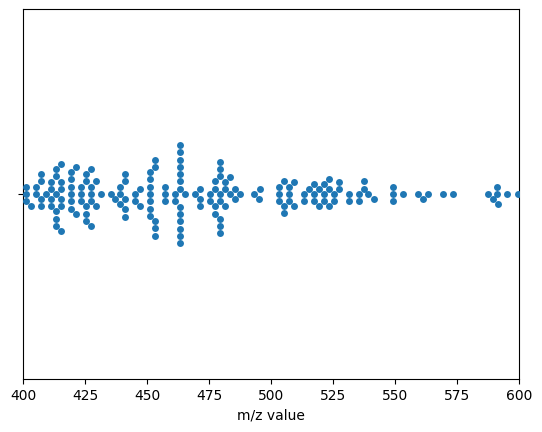

In [8]:
mzref_path = '/home/dewey/CoreMS/tests/tests_data/ftms/nom_pos_cwd.ref'

mzref = pd.read_csv(mzref_path)

fig, ax = plt.subplots()
ax = sns.swarmplot(data = mzref, ax = ax, x = 'm/z value')
ax.set_xlim(400,600)

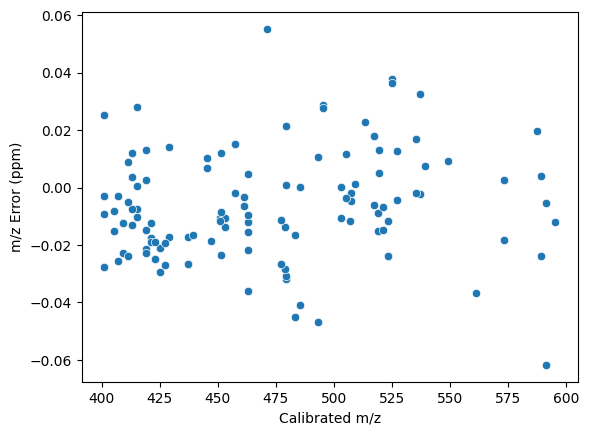

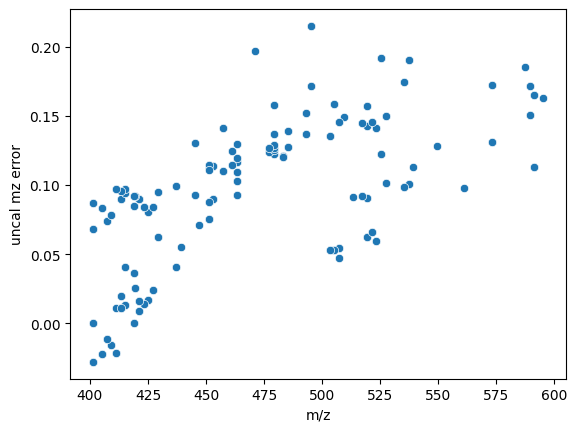

In [25]:
data_df = spring_asgn

df_both = data_df.features_in_both
df_full = pd.concat([data_df.features_in_full_only, df_both[df_both['Window Size (m/z)'] == '1000']])
df_narrow = pd.concat([data_df.features_in_narrow_only, df_both[df_both['Window Size (m/z)'] == '100']])

dd = pd.concat([df_both, df_full,df_narrow])

refmzs = mzref['m/z value']

dd = dd[dd['Molecular Formula'].isin(mzref['ion formula'])] 
df = dd
df['uncal mz error'] = (df['m/z'] - df['Calculated m/z']) / df['Calculated m/z'] * 1e6
#df = df[(df['Heteroatom Class'] == 'P1 O10') | (df['Heteroatom Class'] == 'P1 O11')]
fig, ax = plt.subplots()
ax = sns.scatterplot(data=df, x = 'Calibrated m/z', y='m/z Error (ppm)', ax = ax, legend = True, palette = sns.color_palette('colorblind'))
plt.show()

fig, ax = plt.subplots()

ax = sns.scatterplot(data=df, x = 'm/z', y='uncal mz error',ax = ax, legend = True, palette = sns.color_palette('viridis'))
plt.show()

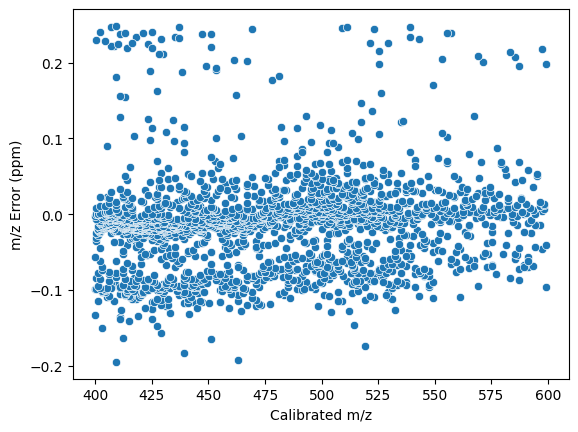

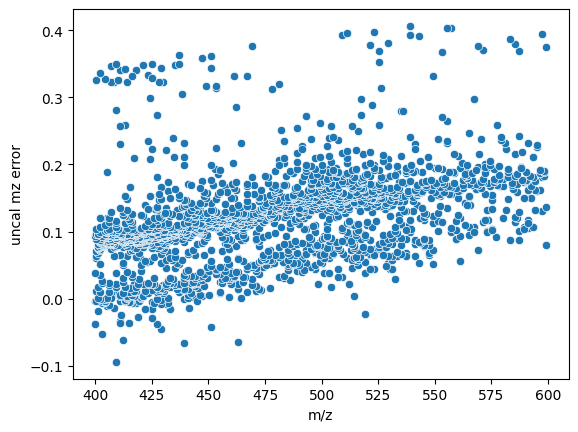

In [11]:
data_df = spring_asgn

df_both = data_df.features_in_both
df_full = pd.concat([data_df.features_in_full_only, df_both[df_both['Window Size (m/z)'] == '1000']])
df_narrow = pd.concat([data_df.features_in_narrow_only, df_both[df_both['Window Size (m/z)'] == '100']])

dd = pd.concat([df_both, df_full,df_narrow])

hetero = 'P'
df = df_full
df['uncal mz error'] = (df['m/z'] - df['Calculated m/z']) / df['Calculated m/z'] * 1e6
#df = df[(df['Heteroatom Class'] == 'P1 O10') | (df['Heteroatom Class'] == 'P1 O11')]
fig, ax = plt.subplots()
ax = sns.scatterplot(data=df, x = 'Calibrated m/z', y='m/z Error (ppm)', ax = ax, legend = True, palette = sns.color_palette('colorblind'))
plt.show()

fig, ax = plt.subplots()

ax = sns.scatterplot(data=df, x = 'm/z', y='uncal mz error',ax = ax, legend = True, palette = sns.color_palette('viridis'))
plt.show()

In [ ]:
## GENERAL PLOTTING FUNCS
def vanKrevelen(df,ax,hcol,col,leg=False):
    pal = sns.set_palette(sns.color_palette('mako'), n_colors=len(df[hcol].unique()))
    if leg is False:
        if len(df['Peak Height'] > 0):
            ax = sns.scatterplot(data=df,x='O/C',y='H/C',size = (df['Peak Height']/max(df['Peak Height'])),hue = hcol,ax = ax,sizes=(20, 100),palette = pal, alpha = 0.5, legend=False) 
            ax.set_ylim(0.,3.)
            ax.set_xlim(0.,1.5)
    else:
        if len(df['Peak Height'] > 0):
            ax = sns.scatterplot(data=df,x='O/C',y='H/C',size = (df['Peak Height']/max(df['Peak Height'])),hue = hcol,ax = ax,sizes=(20, 100), palette = pal, alpha = 0.5) 
            ax.set_ylim(0.,3.)
            ax.set_xlim(0.,1.5)

def panelLabel(ax,lbl):
    ax.text(-.15, 1.1,lbl,
    horizontalalignment='center',
    verticalalignment='center',
    transform = ax.transAxes, fontweight='bold', fontsize = 10)

In [ ]:
## m/z v. assignment error plots 
def plotMzVError(results,element1, element2):
    import itertools
    # set palette 
    #itertools.cycle(pallete)
    

    fig, (ax1, ax3) = plt.subplots(2, 1, figsize = (6,4))

    itertools.cycle(sns.color_palette())
    df = results.features_in_both
    ax1 =sns.scatterplot(data=df[(df['mol_class']!='Unassigned') & (df[element1]>0)], x="m/z", y="m/z Error (ppm)",alpha = 0.5, hue=element1,  ax = ax1)
    ax1.legend(frameon = False, bbox_to_anchor= (1.0,0.5), loc = 'center left')
    L = ax1.legend(frameon = False,title = element1+' atoms', bbox_to_anchor= (1.0,0.5), loc = 'center left')
    n = len(L.get_texts())
    for i in range(n):
        L.get_texts()[i].set_text(str(int(i+1)))

    itertools.cycle(sns.color_palette('mako'))
    df = results.features_in_both
    ax3 =sns.scatterplot(data=df[(df['mol_class']!='Unassigned') & (df[element2]>0)], x="m/z", y="m/z Error (ppm)",alpha = 0.5,hue=element2,palette = sns.color_palette('colorblind'), ax = ax3)
    L = ax3.legend(frameon = False,title = element2+' atoms', bbox_to_anchor= (1.0,0.5), loc = 'center left')
    n = len(L.get_texts())
    for i in range(n):
        L.get_texts()[i].set_text(str(int(i+1)))

    fig.tight_layout()
    axs = [ax1, ax3]
    lbls = ['a','b']
    for ax, lbl in zip(axs,lbls):
        panelLabel(ax,lbl)
    plt.savefig(svdir+'mz_v_error_both_windows_'+results.dataset_name+'_'+element1+'_'+element2+'.pdf', bbox_inches = 'tight')


    fig, (ax2,ax4) = plt.subplots(2, 1, figsize = (6,4))

    itertools.cycle(sns.color_palette())
    df = results.features_in_narrow_only
    ax2 =sns.scatterplot(data=df[(df['mol_class']!='Unassigned') & (df[element1]>0)], x="m/z", y="m/z Error (ppm)",alpha = 0.5,hue=element1,ax = ax2)
    ax2.legend(frameon = False, bbox_to_anchor= (1.0,0.5), loc = 'center left')
    L = ax2.legend(frameon = False,title = element1+' atoms', bbox_to_anchor= (1.0,0.5), loc = 'center left')
    n = len(L.get_texts())
    for i in range(n):
        L.get_texts()[i].set_text(str(int(i+1)))

    itertools.cycle(sns.color_palette('mako'))
    df = df = results.features_in_narrow_only
    ax4 =sns.scatterplot(data=df[(df['mol_class']!='Unassigned') & (df[element2]>0)], x="m/z", y="m/z Error (ppm)",alpha = 0.5,hue=element2,palette = sns.color_palette('colorblind'), ax = ax4)
    L = ax4.legend(frameon = False,title = element2+' atoms', bbox_to_anchor= (1.0,0.5), loc = 'center left')
    n = len(L.get_texts())
    for i in range(n):
        L.get_texts()[i].set_text(str(int(i+1)))

    axs = [ax2, ax4]
    lbls = ['a','b']
    for ax, lbl in zip(axs,lbls):
        panelLabel(ax,lbl)


    fig.tight_layout()
    plt.savefig(svdir+'mz_v_error_narrow_window_'+results.dataset_name+'_'+element1+'_'+element2+'.pdf', bbox_inches = 'tight')


In [ ]:
## PLOT CHO, CHON error for both windows

data_df = spring_asgn

df_both = data_df.features_in_both
df_full = pd.concat([data_df.features_in_full_only, df_both[df_both['Window Size (m/z)'] == '1000']])
df_narrow = pd.concat([data_df.features_in_narrow_only, df_both[df_both['Window Size (m/z)'] == '200']])

print(len(df_both))
print(len(df_full))
print(len(df_narrow))

print(max(df_full['m/z']))
dd = pd.concat([df_both, df_full,df_narrow])

molclass = [ 'CHO','CHON','CHOP']

xmin = -0.25
xmax = 0.25

hc = 'mol_class'

fig, ((ax3,ax4),(ax5,ax6)) = plt.subplots(2, 2, figsize = (6,6))

ax = ax3
df = df_full[df_full['mol_class'].isin(molclass)]
ax = sns.kdeplot(data=df,x='m/z Error (ppm)',hue=hc, ax=ax, legend = False, palette = sns.color_palette('colorblind'))
ax.axvline(0, color = 'gray', linestyle = ':')
ax.set_xlim(xmin,xmax)
ax.set_title('All in full')

ax = ax5
df = df_narrow[df_narrow['mol_class'].isin(molclass)]
ax = sns.kdeplot(data=df,x='m/z Error (ppm)',hue=hc, ax=ax, legend  = False, palette = sns.color_palette('colorblind'))
ax.axvline(0, color = 'gray', linestyle = ':')
ax.set_xlim(xmin,xmax)
ax.set_xlim(xmin,xmax)
ax.set_title('All in narrow')



ax = ax4
df = data_df.features_in_full_only[data_df.features_in_full_only['mol_class'].isin(molclass)]
ax = sns.kdeplot(data=df,x='m/z Error (ppm)',hue=hc, ax=ax, legend = False, palette = sns.color_palette('colorblind'))
ax.axvline(0, color = 'gray', linestyle = ':')
ax.set_xlim(xmin,xmax)
ax.set_title('Full only')

ax = ax6
df = data_df.features_in_narrow_only[data_df.features_in_narrow_only['mol_class'].isin(molclass)]
ax = sns.kdeplot(data=df,x='m/z Error (ppm)',hue=hc, ax=ax, palette = sns.color_palette('colorblind'))
ax.axvline(0, color = 'gray', linestyle = ':')
ax.set_xlim(xmin,xmax)
ax.set_title('Narrow only')

lbls_art = []
lbls = ['a','b','c','d','e']
axs = [ax3,ax4,ax5,ax6]
for lbl, ax in zip(lbls,axs):
    l = ax.text(-0.15, 1.05,lbl,
        horizontalalignment='center',
        verticalalignment='center',
        transform = ax.transAxes, fontweight='bold', fontsize = 10)
    lbls_art.append(l)


legend = ax6.get_legend()
handles = legend.legendHandles
legend.remove()
labels = molclass
leg = fig.legend(handles, labels, bbox_to_anchor=(1.02, 0.5), loc='center left',frameon=False, borderaxespad=0, title = 'Mol. Class', prop={'size': 8})

fig.tight_layout()

#plt.show()
sns.despine()
lbla, lblb, lblc, lbld= lbls_art
plt.show()
#plt.savefig(svdir + 'mz_error_CHO_CHON_windows_spring-env.pdf', bbox_extra_artists=(leg,lbla,lblb,lblc,lbld), bbox_inches='tight')

In [ ]:
## Plot assignment error, Na, S, P, Fe, Cu atoms
data_df = spring_asgn

df_full = pd.concat([data_df.features_in_full_only, df_both[df_both['Window Size (m/z)'] == '1000']])
df_narrow = pd.concat([data_df.features_in_narrow_only, df_both[df_both['Window Size (m/z)'] == '200']])

dd = pd.concat([df_both, df_full,df_narrow])
el = 'N'
xmin = -0.25
xmax = 0.25

fig, ((ax3,ax4),(ax5,ax6)) = plt.subplots(2, 2, figsize = (6,6))

ax = ax3
df = df_full[df_full[el]>0]
ax = sns.kdeplot(data=df,x='m/z Error (ppm)', ax=ax, legend = False, hue=el,palette = sns.color_palette('colorblind')) #hue='N',
ax.axvline(0, color = 'gray', linestyle = ':')
ax.set_xlim(xmin,xmax)
ax.set_title('All in full')

ax = ax5
df = df_narrow[df_narrow[el]>0]
ax = sns.kdeplot(data=df,x='m/z Error (ppm)', ax=ax, legend  = False, hue=el,palette = sns.color_palette('colorblind')) #
ax.axvline(0, color = 'gray', linestyle = ':')
ax.set_xlim(xmin,xmax)
ax.set_xlim(xmin,xmax)
ax.set_title('All in narrow')



ax = ax4
df = data_df.features_in_full_only[data_df.features_in_full_only[el]>0]
ax = sns.kdeplot(data=df,x='m/z Error (ppm)', ax=ax, legend = False, hue=el,palette = sns.color_palette('colorblind')) #hue='N',
ax.axvline(0, color = 'gray', linestyle = ':')
ax.set_xlim(xmin,xmax)
ax.set_title('Full only')

ax = ax6
df = data_df.features_in_narrow_only[data_df.features_in_narrow_only[el]>0]
ax = sns.kdeplot(data=df,x='m/z Error (ppm)', ax=ax, hue=el,palette = sns.color_palette('colorblind')) #hue='N',
ax.axvline(0, color = 'gray', linestyle = ':')
ax.set_xlim(xmin,xmax)
ax.set_title('Narrow only')


lbls_art = []
lbls = ['a','b','c','d','e']
axs = [ax3,ax4,ax5,ax6]
for lbl, ax in zip(lbls,axs):
    l = ax.text(-0.15, 1.05,lbl,
        horizontalalignment='center',
        verticalalignment='center',
        transform = ax.transAxes, fontweight='bold', fontsize = 10)
    lbls_art.append(l)


legend = ax6.get_legend()
handles = legend.legendHandles
legend.remove()
labels = [1,2,3,4]
leg = fig.legend(handles, labels, bbox_to_anchor=(1.02, 0.5), loc='center left',frameon=False, borderaxespad=0, title = el +' Atoms', prop={'size': 8})

fig.tight_layout()

#plt.show()
sns.despine()
lbla, lblb, lblc, lbld= lbls_art
#plt.savefig(svdir + 'mz_error_'+el+'_windows_spring-env.pdf', bbox_extra_artists=(leg,lbla,lblb,lblc,lbld), bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(figsize = (3,3))
df_both = data_df.features_in_both
df = df_both[df_both[el]>0]
ax = sns.kdeplot(data=df,x='m/z Error (ppm)', ax=ax, hue=el,palette = sns.color_palette('colorblind'))
ax.axvline(0, color = 'gray', linestyle = ':')
ax.set_xlim(xmin,xmax)
ax.set_title('Features in both windows')
legend = ax.get_legend()
handles = legend.legendHandles
legend.remove()
labels = [1,2,3,4]
ax.legend(handles, labels, bbox_to_anchor=(1.02, 0.5), loc='center left',frameon=False, borderaxespad=0, title = el+' Atoms', prop={'size': 8})
sns.despine()
#plt.savefig(svdir + 'mz_error_'+el+'_BOTH_spring-env.pdf', bbox_inches='tight')
plt.show()


In [ ]:
# get assign stats
data_df = spring_asgn
el = 'N'
df_both = data_df.features_in_both
df_full = pd.concat([data_df.features_in_full_only, df_both[df_both['Window Size (m/z)'] == '1000']])
df_full = df_full[df_full['Cu']>0]
df = df_full[df_full[el]>0]
print('Full window')
print('%s features with Cu' %(len(df_full)))
print('%s features with Cu & any %s' %(len(df),el))
df = df_full[df_full[el]==1]
print('%s features with Cu & 1 %s' %(len(df),el))
df = df_full[df_full[el]==2]
print('%s features with Cu & 2 %s' %(len(df),el))
df = df_full[df_full[el]==3]
print('%s features with Cu & 3 %s' %(len(df),el))
df = df_full[df_full[el]==4]
print('%s features with Cu & 4 %s' %(len(df),el))

df_narrow = pd.concat([data_df.features_in_narrow_only, df_both[df_both['Window Size (m/z)'] == '200']])
df_narrow = df_narrow[df_narrow['Cu']>0]

df = df_narrow[df_narrow[el]>0]
print('Narrow window')
print('%s features with Cu' %(len(df_narrow)))
print('%s features with Cu & any %s' %(len(df),el))
df = df_narrow[df_narrow[el]==1]
print('%s features with Cu & 1 %s' %(len(df),el))
df = df_narrow[df_narrow[el]==2]
print('%s features with Cu & 2 %s' %(len(df),el))
df = df_narrow[df_narrow[el]==3]
print('%s features with Cu & 3 %s' %(len(df),el))
df = df_narrow[df_narrow[el]==4]
print('%s features with Cu & 4 %s' %(len(df),el))

df_both = data_df.features_in_both
df_both = df_both[df_both['Cu']>0]
df = df_both[df_both[el]>0]
print('Common to both windows')
print('%s features with Cu' %(len(df_both)))
print('%s features with Cu & any %s' %(len(df),el))
df = df_both[df_both[el]==1]
print('%s features with Cu & 1 %s' %(len(df),el))
df = df_both[df_both[el]==2]
print('%s features with Cu & 2 %s' %(len(df),el))
df = df_both[df_both[el]==3]
print('%s features with Cu & 3 %s' %(len(df),el))
df = df_both[df_both[el]==4]
print('%s features with Cu & 4 %s' %(len(df),el))

In [ ]:
## Plot assignment error, Na, S, P, Fe, Cu atoms
data_df = spring_asgn

df_full = pd.concat([data_df.features_in_full_only, df_both[df_both['Window Size (m/z)'] == '1000']])
df_full = df_full[df_full['Cu']>0]
df_narrow = pd.concat([data_df.features_in_narrow_only, df_both[df_both['Window Size (m/z)'] == '200']])
df_narrow = df_narrow[df_narrow['Cu']>0]

dd = pd.concat([df_both, df_full,df_narrow])
el = 'Na'
xmin = -0.25
xmax = 0.25

fig, ((ax3,ax4),(ax5,ax6)) = plt.subplots(2, 2, figsize = (6,6))

ax = ax3
df = df_full[df_full[el]>0]
ax = sns.kdeplot(data=df,x='m/z Error (ppm)', ax=ax, legend = False, hue=el,palette = sns.color_palette('colorblind')) #hue='N',
ax.axvline(0, color = 'gray', linestyle = ':')
ax.set_xlim(xmin,xmax)
ax.set_title('All in full')

ax = ax5
df = df_narrow[df_narrow[el]>0]
ax = sns.kdeplot(data=df,x='m/z Error (ppm)', ax=ax, legend  = False, hue=el,palette = sns.color_palette('colorblind')) #
ax.axvline(0, color = 'gray', linestyle = ':')
ax.set_xlim(xmin,xmax)
ax.set_xlim(xmin,xmax)
ax.set_title('All in narrow')



ax = ax4
df = data_df.features_in_full_only[data_df.features_in_full_only['Cu']>0]
df = df[df[el]>0]
print(len(df))
ax = sns.kdeplot(data=df,x='m/z Error (ppm)', ax=ax, legend = False, hue=el,palette = sns.color_palette('colorblind')) #hue='N',
ax.axvline(0, color = 'gray', linestyle = ':')
ax.set_xlim(xmin,xmax)
ax.set_title('Full only')

ax = ax6
df = data_df.features_in_narrow_only[data_df.features_in_narrow_only['Cu']>0]
df = df[df[el]>0]
ax = sns.kdeplot(data=df,x='m/z Error (ppm)', ax=ax, hue=el,palette = sns.color_palette('colorblind')) #hue='N',
ax.axvline(0, color = 'gray', linestyle = ':')
ax.set_xlim(xmin,xmax)
ax.set_title('Narrow only')


lbls_art = []
lbls = ['a','b','c','d','e']
axs = [ax3,ax4,ax5,ax6]
for lbl, ax in zip(lbls,axs):
    l = ax.text(-0.15, 1.05,lbl,
        horizontalalignment='center',
        verticalalignment='center',
        transform = ax.transAxes, fontweight='bold', fontsize = 10)
    lbls_art.append(l)


legend = ax6.get_legend()
handles = legend.legendHandles
legend.remove()
labels = [1,2,3,4]
#leg = fig.legend(handles, labels, bbox_to_anchor=(1.02, 0.5), loc='center left',frameon=False, borderaxespad=0, title = el +' Atoms', prop={'size': 8})

fig.tight_layout()

#plt.show()
sns.despine()
lbla, lblb, lblc, lbld= lbls_art
plt.savefig(svdir + 'mz_error_Cu_'+el+'_windows_spring-env.pdf', bbox_extra_artists=(lbla,lblb,lblc,lbld), bbox_inches='tight')


fig, ax = plt.subplots(figsize = (3,3))
df_both = data_df.features_in_both
df_both = df_both[df_both['Cu']>0]

df = df_both[df_both[el]>0]
ax = sns.kdeplot(data=df,x='m/z Error (ppm)', ax=ax, hue=el,palette = sns.color_palette('colorblind'))
ax.axvline(0, color = 'gray', linestyle = ':')
ax.set_xlim(xmin,xmax)
ax.set_title('Features in both windows')
legend = ax.get_legend()
handles = legend.legendHandles
legend.remove()
labels = [1,2,3,4]
ax.legend(handles, labels, bbox_to_anchor=(1.02, 0.5), loc='center left',frameon=False, borderaxespad=0, title = el+' Atoms', prop={'size': 8})
sns.despine()
plt.savefig(svdir + 'mz_error_Cu_'+el+'_BOTH_spring-env.pdf', bbox_inches='tight')



In [ ]:
for i in _ih[-15:]:
    print(i)

In [ ]:
## Plot assignment error, Na, S, P, Fe, Cu atoms
data_df = spring_asgn

df_full = pd.concat([data_df.features_in_full_only, df_both[df_both['Window Size (m/z)'] == '1000']])
df_narrow = pd.concat([data_df.features_in_narrow_only, df_both[df_both['Window Size (m/z)'] == '200']])

dd = pd.concat([df_both, df_full,df_narrow])
el = 'Cu'
xmin = -0.25
xmax = 0.25

fig, ((ax3,ax4),(ax5,ax6)) = plt.subplots(2, 2, figsize = (6,6))

ax = ax3
df = df_full[df_full[el]>0]
ax = sns.kdeplot(data=df,x='m/z Error (ppm)', ax=ax, legend = False, hue=el,palette = sns.color_palette('colorblind')) #hue='N',
ax.axvline(0, color = 'gray', linestyle = ':')
ax.set_xlim(xmin,xmax)
ax.set_title('All in full')

ax = ax5
df = df_narrow[df_narrow[el]>0]
ax = sns.kdeplot(data=df,x='m/z Error (ppm)', ax=ax, legend  = False, hue=el,palette = sns.color_palette('colorblind')) #
ax.axvline(0, color = 'gray', linestyle = ':')
ax.set_xlim(xmin,xmax)
ax.set_xlim(xmin,xmax)
ax.set_title('All in narrow')



ax = ax4
df = data_df.features_in_full_only[data_df.features_in_full_only[el]>0]
ax = sns.kdeplot(data=df,x='m/z Error (ppm)', ax=ax, legend = False, hue=el,palette = sns.color_palette('colorblind')) #hue='N',
ax.axvline(0, color = 'gray', linestyle = ':')
ax.set_xlim(xmin,xmax)
ax.set_title('Full only')

ax = ax6
df = data_df.features_in_narrow_only[data_df.features_in_narrow_only[el]>0]
ax = sns.kdeplot(data=df,x='m/z Error (ppm)', ax=ax, hue=el,palette = sns.color_palette('colorblind')) #hue='N',
ax.axvline(0, color = 'gray', linestyle = ':')
ax.set_xlim(xmin,xmax)
ax.set_title('Narrow only')


lbls_art = []
lbls = ['a','b','c','d','e']
axs = [ax3,ax4,ax5,ax6]
for lbl, ax in zip(lbls,axs):
    l = ax.text(-0.15, 1.05,lbl,
        horizontalalignment='center',
        verticalalignment='center',
        transform = ax.transAxes, fontweight='bold', fontsize = 10)
    lbls_art.append(l)


legend = ax6.get_legend()
handles = legend.legendHandles
legend.remove()
labels = [1,2,3,4]
leg = fig.legend(handles, labels, bbox_to_anchor=(1.02, 0.5), loc='center left',frameon=False, borderaxespad=0, title = el +' Atoms', prop={'size': 8})

fig.tight_layout()

#plt.show()
sns.despine()
lbla, lblb, lblc, lbld= lbls_art
plt.savefig(svdir + 'mz_error_'+el+'_windows_spring-env.pdf', bbox_extra_artists=(leg,lbla,lblb,lblc,lbld), bbox_inches='tight')


fig, ax = plt.subplots(figsize = (3,3))
df_both = data_df.features_in_both
df = df_both[df_both[el]>0]
ax = sns.kdeplot(data=df,x='m/z Error (ppm)', ax=ax, hue=el,palette = sns.color_palette('colorblind'))
ax.axvline(0, color = 'gray', linestyle = ':')
ax.set_xlim(xmin,xmax)
ax.set_title('Features in both windows')
legend = ax.get_legend()
handles = legend.legendHandles
legend.remove()
labels = [1,2,3,4]
ax.legend(handles, labels, bbox_to_anchor=(1.02, 0.5), loc='center left',frameon=False, borderaxespad=0, title = el+' Atoms', prop={'size': 8})
sns.despine()
plt.savefig(svdir + 'mz_error_'+el+'_BOTH_spring-env.pdf', bbox_inches='tight')



In [ ]:
## Plot assignment error, N atoms
data_df = spring_asgn

df_full = pd.concat([data_df.features_in_full_only, df_both[df_both['Window Size (m/z)'] == '1000']])
df_narrow = pd.concat([data_df.features_in_narrow_only, df_both[df_both['Window Size (m/z)'] == '200']])

dd = pd.concat([df_both, df_full,df_narrow])

molclass = ['CHO', 'CHON']

xmin = -0.2
xmax = 0.2

fig, ((ax3,ax4),(ax5,ax6)) = plt.subplots(2, 2, figsize = (6,6))

ax = ax3
df = df_full[df_full['N']>0]
ax = sns.kdeplot(data=df,x='m/z Error (ppm)', ax=ax, legend = False, hue='N',palette = sns.color_palette('colorblind')) #hue='N',
ax.axvline(0, color = 'gray', linestyle = ':')
ax.set_xlim(xmin,xmax)
ax.set_title('All in full')

ax = ax5
df = df_narrow[df_narrow['N']>0]
ax = sns.kdeplot(data=df,x='m/z Error (ppm)', ax=ax, legend  = False, hue='N',palette = sns.color_palette('colorblind')) #
ax.axvline(0, color = 'gray', linestyle = ':')
ax.set_xlim(xmin,xmax)
ax.set_xlim(xmin,xmax)
ax.set_title('All in narrow')



ax = ax4
df = data_df.features_in_full_only[data_df.features_in_full_only['N']>0]
ax = sns.kdeplot(data=df,x='m/z Error (ppm)', ax=ax, legend = False, hue='N',palette = sns.color_palette('colorblind')) #hue='N',
ax.axvline(0, color = 'gray', linestyle = ':')
ax.set_xlim(xmin,xmax)
ax.set_title('Full only')

ax = ax6
df = data_df.features_in_narrow_only[data_df.features_in_narrow_only['N']>0]
ax = sns.kdeplot(data=df,x='m/z Error (ppm)', ax=ax, hue='N',palette = sns.color_palette('colorblind')) #hue='N',
ax.axvline(0, color = 'gray', linestyle = ':')
ax.set_xlim(xmin,xmax)
ax.set_title('Narrow only')


lbls_art = []
lbls = ['a','b','c','d','e']
axs = [ax3,ax4,ax5,ax6]
for lbl, ax in zip(lbls,axs):
    l = ax.text(-0.15, 1.05,lbl,
        horizontalalignment='center',
        verticalalignment='center',
        transform = ax.transAxes, fontweight='bold', fontsize = 10)
    lbls_art.append(l)


legend = ax6.get_legend()
handles = legend.legendHandles
legend.remove()
labels = [1,2,3,4]
leg = fig.legend(handles, labels, bbox_to_anchor=(1.02, 0.5), loc='center left',frameon=False, borderaxespad=0, title = 'N Atoms', prop={'size': 8})

fig.tight_layout()

#plt.show()
sns.despine()
lbla, lblb, lblc, lbld= lbls_art
plt.savefig(svdir + 'mz_error_N_windows_spring-env.pdf', bbox_extra_artists=(leg,lbla,lblb,lblc,lbld), bbox_inches='tight')


fig, ax = plt.subplots(figsize = (3,3))
df_both = data_df.features_in_both
df = df_both[df_both['N']>0]
ax = sns.kdeplot(data=df,x='m/z Error (ppm)', ax=ax, hue='N',palette = sns.color_palette('colorblind'))
ax.axvline(0, color = 'gray', linestyle = ':')
ax.set_xlim(xmin,xmax)
ax.set_title('Features in both windows')
legend = ax.get_legend()
handles = legend.legendHandles
legend.remove()
labels = [1,2,3,4]
ax.legend(handles, labels, bbox_to_anchor=(1.02, 0.5), loc='center left',frameon=False, borderaxespad=0, title = 'N Atoms', prop={'size': 8})
sns.despine()
plt.savefig(svdir + 'mz_error_N_BOTH_spring-env.pdf', bbox_inches='tight')



In [ ]:
## PLOT DBE KDEs error for both windows

data_df = spring_asgn

df_both = data_df.features_in_both
df_full = pd.concat([data_df.features_in_full_only, df_both[df_both['Window Size (m/z)'] == '1000']])
df_narrow = pd.concat([data_df.features_in_narrow_only, df_both[df_both['Window Size (m/z)'] == '200']])

dd = pd.concat([df_full,df_narrow])


"""xmin = -1
xmax = 20"""

c='S/N'
hc = 'Window Size (m/z)'

fig, ax = plt.subplots(figsize = (3,3))

ax = sns.kdeplot(data=dd,x=c, ax=ax, hue=hc,palette = sns.color_palette('colorblind'), legend = True)
#ax.set_xlim(xmin,xmax)


legend = ax.get_legend()
handles = legend.legendHandles
labels = ['1000 m/z', '200 m/z']
ax.legend(handles, labels, bbox_to_anchor=(1.02, 0.5), loc='center left',frameon=False, borderaxespad=0,  prop={'size': 8})
sns.despine()
c = 'SN'
plt.savefig(svdir + 'mz_error_'+c+'_BOTH_spring-env.pdf', bbox_inches='tight')



In [ ]:


fig, ((ax3,ax4),(ax5,ax6)) = plt.subplots(2, 2, figsize = (6,6))

ax = ax3
ax = sns.kdeplot(data=df,x='DBE',hue=hc, ax=ax, legend = False, palette = sns.color_palette('colorblind'))
ax.set_xlim(xmin,xmax)
ax.set_title('All in full')

ax = ax5
ax = sns.kdeplot(data=df,x='DBE',hue=hc, ax=ax, legend  = False, palette = sns.color_palette('colorblind'))
ax.set_xlim(xmin,xmax)
ax.set_title('All in narrow')



ax = ax4
df = data_df.features_in_full_only[data_df.features_in_full_only['mol_class'].isin(molclass)]
ax = sns.kdeplot(data=df,x='DBE',hue=hc, ax=ax, legend = False, palette = sns.color_palette('colorblind'))
ax.set_xlim(xmin,xmax)
ax.set_title('Full only')

ax = ax6
df = data_df.features_in_narrow_only[data_df.features_in_narrow_only['mol_class'].isin(molclass)]
ax = sns.kdeplot(data=df,x='DBE',hue=hc, ax=ax, palette = sns.color_palette('colorblind'))
ax.set_xlim(xmin,xmax)
ax.set_title('Narrow only')

lbls_art = []
lbls = ['a','b','c','d','e']
axs = [ax3,ax4,ax5,ax6]
for lbl, ax in zip(lbls,axs):
    l = ax.text(-0.15, 1.05,lbl,
        horizontalalignment='center',
        verticalalignment='center',
        transform = ax.transAxes, fontweight='bold', fontsize = 10)
    lbls_art.append(l)


legend = ax6.get_legend()
handles = legend.legendHandles
legend.remove()
labels = molclass
leg = fig.legend(handles, labels, bbox_to_anchor=(1.02, 0.5), loc='center left',frameon=False, borderaxespad=0, title = 'Mol. Class', prop={'size': 8})

fig.tight_layout()

#plt.show()
sns.despine()
lbla, lblb, lblc, lbld= lbls_art
plt.savefig(svdir + 'mz_error_DBE_windows_spring-env.pdf', bbox_extra_artists=(leg,lbla,lblb,lblc,lbld), bbox_inches='tight')


fig, ax = plt.subplots(figsize = (3,3))
df_both = data_df.features_in_both

ax = sns.kdeplot(data=df,x='DBE', ax=ax, hue=el,palette = sns.color_palette('colorblind'), legend = False)
ax.set_xlim(xmin,xmax)
ax.set_title('Features in both windows')
legend = ax.get_legend()
handles = legend.legendHandles
legend.remove()
labels = [1,2,3,4]
ax.legend(handles, labels, bbox_to_anchor=(1.02, 0.5), loc='center left',frameon=False, borderaxespad=0, title = el+' Atoms', prop={'size': 8})
sns.despine()
plt.savefig(svdir + 'mz_error_'+el+'_BOTH_spring-env.pdf', bbox_inches='tight')

In [ ]:
## PLOT CHO, CHON error for both windows

data_df = spring_asgn

df_both = data_df.features_in_both
df_full = pd.concat([data_df.features_in_full_only, df_both[df_both['Window Size (m/z)'] == '1000']])
df_narrow = pd.concat([data_df.features_in_narrow_only, df_both[df_both['Window Size (m/z)'] == '200']])

print(len(df_both))
print(len(df_full))
print(len(df_narrow))

print(max(df_full['m/z']))
dd = pd.concat([df_both, df_full,df_narrow])

molclass = [ 'CHO','CHON']

xmin = -0.25
xmax = 0.25

hc = 'mol_class'

fig, ((ax3,ax4),(ax5,ax6)) = plt.subplots(2, 2, figsize = (6,6))

ax = ax3
df = df_full[df_full['mol_class'].isin(molclass)]
ax = sns.kdeplot(data=df,x='m/z Error (ppm)',hue=hc, ax=ax, legend = False, palette = sns.color_palette('colorblind'))
ax.axvline(0, color = 'gray', linestyle = ':')
ax.set_xlim(xmin,xmax)
ax.set_title('All in full')

ax = ax5
df = df_narrow[df_narrow['mol_class'].isin(molclass)]
ax = sns.kdeplot(data=df,x='m/z Error (ppm)',hue=hc, ax=ax, legend  = False, palette = sns.color_palette('colorblind'))
ax.axvline(0, color = 'gray', linestyle = ':')
ax.set_xlim(xmin,xmax)
ax.set_xlim(xmin,xmax)
ax.set_title('All in narrow')



ax = ax4
df = data_df.features_in_full_only[data_df.features_in_full_only['mol_class'].isin(molclass)]
ax = sns.kdeplot(data=df,x='m/z Error (ppm)',hue=hc, ax=ax, legend = False, palette = sns.color_palette('colorblind'))
ax.axvline(0, color = 'gray', linestyle = ':')
ax.set_xlim(xmin,xmax)
ax.set_title('Full only')

ax = ax6
df = data_df.features_in_narrow_only[data_df.features_in_narrow_only['mol_class'].isin(molclass)]
ax = sns.kdeplot(data=df,x='m/z Error (ppm)',hue=hc, ax=ax, palette = sns.color_palette('colorblind'))
ax.axvline(0, color = 'gray', linestyle = ':')
ax.set_xlim(xmin,xmax)
ax.set_title('Narrow only')

lbls_art = []
lbls = ['a','b','c','d','e']
axs = [ax3,ax4,ax5,ax6]
for lbl, ax in zip(lbls,axs):
    l = ax.text(-0.15, 1.05,lbl,
        horizontalalignment='center',
        verticalalignment='center',
        transform = ax.transAxes, fontweight='bold', fontsize = 10)
    lbls_art.append(l)


legend = ax6.get_legend()
handles = legend.legendHandles
legend.remove()
labels = molclass
leg = fig.legend(handles, labels, bbox_to_anchor=(1.02, 0.5), loc='center left',frameon=False, borderaxespad=0, title = 'Mol. Class', prop={'size': 8})

fig.tight_layout()

#plt.show()
sns.despine()
lbla, lblb, lblc, lbld= lbls_art
plt.show()
#plt.savefig(svdir + 'mz_error_CHO_CHON_windows_spring-env.pdf', bbox_extra_artists=(leg,lbla,lblb,lblc,lbld), bbox_inches='tight')

In [ ]:


'''df_nrw_al = pd.concat([df_narrow, df_both[df_both['Window Size (m/z)']=='200']])
df_nrw_al = df_nrw_al[(df_nrw_al['Cu']>0)&(df_nrw_al['Na']==1) &(df_nrw_al['P']>=0) &
                      (df_nrw_al['S']<=10) &(df_nrw_al['Fe']==0) &(df_nrw_al['N']<=4)]'''


'''print(len(df_full[df_full['Cu']==1]), len(df_narrow[df_narrow['Cu']==1]), print(len(df_both[df_both['Cu']>0])))
ddf = df_full[(df_full['Cu']==1) & (df_full['Na']==1) & (df_full['P']>=0)  &
               (df_full['S']<=15)  & (df_full['N']<=4) & (df_full['Fe']==0)]
ddf['DetectedIn'] = 'Full Only'
ddn = df_narrow[(df_narrow['Cu']==1) & (df_narrow['Na']==0) & (df_narrow['P']<=0) & (df_narrow['S']<=1) & (df_narrow['N']>=4) & (df_narrow['Fe']==0)]
ddn['DetectedIn'] = 'Narrow Only'
ddb = df_both[(df_both['Cu']>0) & (df_both['Na']==0) & (df_both['P']<=0) & (df_both['S']<=1)& (df_both['N']>=4) & (df_both['Fe']==0)]
ddb['DetectedIn'] = 'Both'''


#['mol_class'].isin(['CHO','CHON'])
df_full = df_full[df_full['Fe']>0]
df_full = df_full[df_full['N']>0]
df_full = df_full[df_full['Na']==0]
df_full = df_full[df_full['P']==0]
df_full = df_full[df_full['S']==0]


df_narrow = df_narrow[df_narrow['Fe']>0]
df_narrow = df_narrow[df_narrow['N']>0]
df_narrow = df_narrow[df_narrow['Na']==0]
df_narrow = df_narrow[df_narrow['P']==0]
df_narrow = df_narrow[df_narrow['S']==0]


df_both = df_both[df_both['Fe']>0]
df_both = df_both[df_both['N']>0]
df_both = df_both[df_both['Na']==0]
df_both = df_both[df_both['P']==0]
df_both = df_both[df_both['S']==0]
print(len(df_full))
print(len(df_narrow))
print(len(df_both))
dd = pd.concat([df_both, df_full,df_narrow])

sns.kdeplot(data=dd, x = 'm/z Error (ppm)', palette = sns.color_palette('colorblind'),hue = 'FeatureIn')

#sns.kdeplot(data=df_nrw_al, x = 'm/z Error (ppm)', color = 'red')

plt.axvline(0, linestyle = ':', color='gray')



In [ ]:


for df in [df_full, df_narrow]:

    df1 = df[df['Cu']>0]
    print('%s Cu assignments' %len(df1))
    df2 = df1[df1['N']==1]
    print('%s Cu assignments with 1 N' %len(df2))
    df3 = df1[(df1['N']==2) ]
    print('%s Cu assignments wit 2 N' %len(df3))
    df4 = df1[(df1['N']==3) ]
    print('%s Cu assignments with 3 N' %len(df4))
    df5 = df1[df1['N'] == 4]
    print('%s Cu assignments with 4 N\n' %len(df5))


dd = pd.concat([ df5, df3, df4, df2])
sns.kdeplot(data=dd, x = 'm/z Error (ppm)', palette = sns.color_palette('colorblind'), hue='mol_class')


data_df = spring_asgn

df_full = data_df.features_in_both[ (data_df.features_in_both['Window Size (m/z)']=='1000') 
                                   &(data_df.features_in_both['Cu'] >=1) ]

df_narrow = pd.concat([data_df.features_in_both[ (data_df.features_in_both['Window Size (m/z)']=='200')], 
                        data_df.features_in_narrow_only])
df_narrow = df_narrow[df_narrow['Cu']>=1]
'''
element = 'P'

print('%s Cu assignments in full (400-600 mz)' %len(df_full))
print('%s Cu assignments in nrw (400-600 mz)' %len(df_narrow))

print('%s Cu with %s in full (400-600 mz)' %(len(df_full[df_full[element]>=1]), element))

print('\n%s Cu with %s in nrw (400-600 mz)' %(len(df_narrow[df_narrow[element]>=1]), element))'''


In [ ]:
data_df = spring_asgn

df_full = data_df.features_in_both

df_narrow = data_df.features_in_narrow_only


for df in [df_full, df_narrow]:

    df1 = df[df['Cu']>0]
    print('%s Cu assignments' %len(df1))
    df2 = df1[df1['N']==1]
    print('%s Cu assignments with 1 N' %len(df2))
    df3 = df1[(df1['N']==2) ]
    print('%s Cu assignments wit 2 N' %len(df3))
    df4 = df1[(df1['N']==3) ]
    print('%s Cu assignments with 3 N' %len(df4))
    df5 = df1[df1['N'] == 4]
    print('%s Cu assignments with 4 N\n' %len(df5))


dd = pd.concat([ df5, df3, df4, df2])
sns.kdeplot(data=dd, x = 'm/z Error (ppm)', palette = sns.color_palette('colorblind'), hue='mol_class')


data_df = spring_asgn

df_full = data_df.features_in_both[ (data_df.features_in_both['Window Size (m/z)']=='1000') 
                                   &(data_df.features_in_both['Cu'] >=1) ]

df_narrow = pd.concat([data_df.features_in_both[ (data_df.features_in_both['Window Size (m/z)']=='200')], 
                        data_df.features_in_narrow_only])
df_narrow = df_narrow[df_narrow['Cu']>=1]

element = 'P'

print('%s Cu assignments in full (400-600 mz)' %len(df_full))
print('%s Cu assignments in nrw (400-600 mz)' %len(df_narrow))

print('%s Cu with %s in full (400-600 mz)' %(len(df_full[df_full[element]>=1]), element))

print('\n%s Cu with %s in nrw (400-600 mz)' %(len(df_narrow[df_narrow[element]>=1]), element))


In [ ]:
### make KDE error plots for Cu in Spring-ENV 

def plot_CuN_KDE():
        windows = ['narrow', 'full', 'both']

        xpltl = -0.1
        ypltl = 1.1
        fig,( ax , ax2)= plt.subplots(2,1, figsize=(2.7,4.8))

        ax = plotErrorKde_el(ax,spring_asgn,element1='Cu',element2='N', window = windows[1], max1 = 1, min2 = 1, max2=5)
        #ax = plotErrorKde_el(ax,spring_asgn,element1='C',element2='N', window = windows[1], max1 = 50, min2 = 4, max2=4)

        ax.set_title('1000 m/z window',size=11)
        ax.tick_params(axis='x', labelsize=8)
        ax.tick_params(axis='y', labelsize=8)
        ax.yaxis.set_major_locator(MultipleLocator(1))
        ax.yaxis.set_minor_locator(MultipleLocator(0.25))
        legend = ax.get_legend()
        legend.remove()
        

        '''handles = legend.legendHandles
        labels = [str(i) for i in range(1,5)]
        ax.legend(handles,labels, bbox_to_anchor=(1.0, 0.5), loc='center right',frameon=False, borderaxespad=0, title = 'N atoms', prop={'size': 10})'''

        ax2 = plotErrorKde_el(ax2,spring_asgn,element1='Cu',element2='N', window = windows[0], max1 = 1, min2 = 1, max2=5)
        #ax2 = plotErrorKde_el(ax2,spring_asgn,element1='C',element2='Cu', window = windows[1], max1 = 50, min2 = 1, max2=1)
        ax2.set_title('200 m/z window',size=11)
        legend = ax2.get_legend()
        handles = legend.legendHandles
        labels = [str(i) for i in range(1,5)]
        legend.remove()
        ax2.tick_params(axis='x', labelsize=8)
        ax2.tick_params(axis='y', labelsize=8)
        ax2.yaxis.set_major_locator(MultipleLocator(1))
        ax2.yaxis.set_minor_locator(MultipleLocator(0.25))

        ax = ax 
        lbla =ax.text(xpltl, ypltl,'a',
                horizontalalignment='center',
                verticalalignment='center',
                transform = ax.transAxes, fontweight='bold', fontsize = 12)

        ax =ax2 
        lblb = ax.text(xpltl, ypltl,'b',
                horizontalalignment='center',
                verticalalignment='center',
                transform = ax.transAxes, fontweight='bold', fontsize = 12)
        leg = fig.legend(handles,labels, bbox_to_anchor=(1.0, 0.55), loc='center left',frameon=False, borderaxespad=0, title = 'N atoms', prop={'size': 8})
        sns.despine()

        fig.tight_layout()
        #plt.show()
        plt.savefig(svdir + 'kde_Cu_N_spring-env_nrw&full.pdf', bbox_extra_artists=(lblb,lbla, leg),bbox_inches='tight')



In [ ]:
data_df = spring_asgn

df_full = data_df.features_in_both[ (data_df.features_in_both['Window Size (m/z)']=='1000')]

df_narrow = pd.concat([data_df.features_in_both[ (data_df.features_in_both['Window Size (m/z)']=='200')], 
                        data_df.features_in_narrow_only])

print('%s CHO in full (400-600 mz)' %len(df_full[df_full['mol_class']=='CHO']))
print('%s CHON in full (400-600 mz)' %len(df_full[df_full['mol_class']=='CHON']))
print('%s other in full (400-600 mz)' %len(df_full[(df_full['mol_class']!='CHON')&(df_full['mol_class']!='CHO')]))

print('%s CHO in nrw (400-600 mz)' %len(df_narrow[df_narrow['mol_class']=='CHO']))
print('%s CHON in nrw (400-600 mz)' %len(df_narrow[df_narrow['mol_class']=='CHON']))
print('%s other in nrw (400-600 mz)' %len(df_narrow[(df_narrow['mol_class']!='CHON')&(df_narrow['mol_class']!='CHO')]))

print(df_narrow['mol_class'].unique())
print(df_full['mol_class'].unique())


In [ ]:
data_df = spring_asgn

df_full = data_df.features_in_both[ (data_df.features_in_both['Window Size (m/z)']=='1000') &(data_df.features_in_both['Cu'] >=1) ]

df_narrow = pd.concat([data_df.features_in_both[ (data_df.features_in_both['Window Size (m/z)']=='200')], 
                        data_df.features_in_narrow_only])
df_narrow = df_narrow[df_narrow['Cu']>=1]

element = 'P'

print('%s Cu assignments in full (400-600 mz)' %len(df_full))
print('%s Cu assignments in nrw (400-600 mz)' %len(df_narrow))

print('%s Cu with %s in full (400-600 mz)' %(len(df_full[df_full[element]>=1]), element))

print('\n%s Cu with %s in nrw (400-600 mz)' %(len(df_narrow[df_narrow[element]>=1]), element))


In [ ]:
### make mz v. error ppm plots

plotMzVError(spring_asgn, element1='Na', element2='S')

plotMzVError(wastewater_asgn, element1='N', element2='Cl')

In [ ]:
make_S_VKpanels(wastewater_asgn) 
make_I_VKpanels(wastewater_asgn)
make_F_VKpanels(wastewater_asgn)

In [ ]:
make_Cu_VKpanels(spring_asgn)

In [ ]:
make_N_VKpanels(spring_asgn)
make_N_VKpanels(wastewater_asgn)

In [ ]:
element1 = 'Cu'
element2 = 'N'
max1 = 1
max2 = 5
min2 = 4
data_df = spring_asgn
n = 4
df_cu_full = data_df.features_in_both[(data_df.features_in_both['Cu']>0) & (data_df.features_in_both['Window Size (m/z)']=='1000')]
df = df_cu_full[df_cu_full['N']==n]
print(np.shape(df))

df_cu_narrow = pd.concat([data_df.features_in_both[(data_df.features_in_both['Cu']>0) & (data_df.features_in_both['Window Size (m/z)']=='200')], data_df.features_in_narrow_only[data_df.features_in_narrow_only['Cu']>0]])
df = df_cu_narrow[df_cu_narrow['N']==n]
print(np.shape(df))

In [ ]:
unique_fullmz_range = spring_asgn.features_in_both
unique_fullmz_range = unique_fullmz_range[(unique_fullmz_range[element1]>0) & (unique_fullmz_range[element1]<=max1) & (unique_fullmz_range[element2]>=min2) & (unique_fullmz_range[element2]<=max2)]
print(np.shape(unique_fullmz_range))
print(unique_fullmz_range['N'])

In [ ]:
sns.color_palette('colorblind') 


In [ ]:
plot_CuN_KDE()

In [ ]:
from matplotlib.backends.backend_pdf import PdfPages

icpms_file = '/Users/christiandewey/Library/CloudStorage/Box-Box/Boiteau Lab/Mass Spec Data/Keck iCAP Q/2022/2022-09/Tillamook, Sept 2022/spring_env.csv'
icpms = pd.read_csv(icpms_file, sep=';',header=1)


metals = ['63Cu','56Fe']

fig, ax = plt.subplots()

maxicp = 0 
for me in metals:
    me_key = 'Time %s' %me
    ax.plot(icpms[me_key]/60, icpms[me], label=me)        
    



#ax.set_ylim(0,maxicp*1.1)
ax.set_title('Spring (ENV)')
ax.set_xlabel('Time (min)')
ax.set_ylabel('ICP-MS signal (cps)')
ax.legend(bbox_to_anchor=(1.05,0.5),loc='center left',frameon =False)
ax.set_xlim(0,30)
ax.set_ylim(bottom = 0)

x = np.arange(0.0, 4, 0.01)
ax.fill_between(x, 0,1e6,  color = 'gray',alpha=0.5)
x = np.arange(24, 30, 0.01)
ax.fill_between(x, 0,1e6, color = 'gray', alpha=0.5)
current_yvalues = plt.gca().get_yticks()
ylabs = []
for y in current_yvalues:
    if y == 0:
        d = int(0)
    else:
        d = '{:.1f} x $10^5$'.format(y/1e5)
    ylabs.append(d)
#plt.gca().set_yticklabels(['{:.1f} x $10^5$'.format(y/1e5) for y in current_yvalues])
plt.gca().set_yticklabels(ylabs)
fig.tight_layout()
plt.show()

In [ ]:
from matplotlib.backends.backend_pdf import PdfPages

flist = ['slough_env.csv']  #'spring_env.csv',
title = 'DOM-Cu'
#flist = ['spring_ppl.csv','slough_ppl.csv']
#title = 'PPL SPE Column'
labels = ['Slough'] #'Seep', 
alphas = [1,0.5]
labs = {f:l for f,l in zip(flist,labels)}
transp = {f:a for f,a in zip(flist,alphas)}

dir = '/Users/christiandewey/Library/CloudStorage/Box-Box/Boiteau Lab/Mass Spec Data/Keck iCAP Q/2022/2022-09/Tillamook, Sept 2022/'

metals = ['63Cu']
colors = ['C0', 'C1']
cols = {m:c for m,c in zip(metals,colors)}


fig, ax = plt.subplots()

for me in metals:

    maxicp = 0 

    for f in flist:

        icpms_file = dir + f
        icpms = pd.read_csv(icpms_file, sep=';',header=1)
        mw = me[:2]
        sym = me[2:]
        plab = '$^{%s}$%s' %(mw,sym)
        me_key = 'Time %s' %me
        ax.plot(icpms[me_key]/60, icpms[me], label=plab+', '+labs[f],color = cols[me], alpha = transp[f])        
        

#ax.set_ylim(0,maxicp*1.1)
#ax.set_title(title)
ax.set_xlabel('Time (min)')
ax.set_ylabel('ICP-MS signal (cps)')
#ax.legend(bbox_to_anchor=(1.05,0.5),loc='center left',frameon =False)
ax.legend(bbox_to_anchor=(1.0,1.0),loc='upper right')

ax.set_xlim(0,30)
ax.set_ylim(bottom = 0, top = 1.25e5)
ax.yaxis.set_major_locator(MultipleLocator(2.5e4))

'''x = np.arange(0.0, 4, 0.01)
ax.fill_between(x, 0,1e6,  color = 'gray',alpha=0.5)
x = np.arange(24, 30, 0.01)
ax.fill_between(x, 0,1e6, color = 'gray', alpha=0.5)'''
current_yvalues = plt.gca().get_yticks()
ylabs = []
for y in current_yvalues:
    if y == 0:
        d = int(0)
    else:
        d = '{:.1f} x $10^5$'.format(y/1e5)
    ylabs.append(d)
#plt.gca().set_yticklabels(['{:.1f} x $10^5$'.format(y/1e5) for y in current_yvalues])
plt.gca().set_yticklabels(ylabs)


fig.tight_layout()
plt.show()

In [ ]:
from tabulate import tabulate
geochem = pd.DataFrame(columns = ['Seep', 'Slough'], index = ['pH', 'Conductivity (mS/cm)','DO (mg/L)','T (C)','Total Cu (uM)', 'Total Fe (uM)', 'DOC (mM)'])

seep = [5.5, 1000,0.1, 8, 100,200,4]
slough = [7.2, 200,8, 8, 50,100,3]

geochem['Seep'] = seep
geochem['Slough'] = slough

geochem

ctest = tabulate(geochem, headers=['Seep', 'Slough'], tablefmt='latex')




In [ ]:
alldf = pd.concat([unique_fullmz_456, unique_200mz])
#alldf = unique_100mz_456

times = data_df['Time'].unique()

holder = {}
summary = []
summary2 = []

for mzw in alldf['m/z Window Size'].unique():
    
    sub1 = alldf[alldf['m/z Window Size'] == mzw]

    for t in times:
        
        print(mzw)
        lsh = {}
        lsh['m/z Window Size'] = mzw

        sub2 = sub1[sub1['Time'] == t]

        sub2 = sub2[sub2['S/N'] > 3]
        
        dynamic_range_t = max(sub2['Peak Height']/min(sub2['Peak Height']))
        
        lsh['Time'] = t
        lsh['Dynamic Range'] = dynamic_range_t        
        lsh['n Features'] = len(sub2)
        lsh['Max I'] = max(sub2['Peak Height'])
        lsh['Min I'] = min(sub2['Peak Height'])
        summary.append(lsh)


df=pd.DataFrame(summary)

sns.boxplot(data=df, x="Dynamic Range", y="m/z Window Size")

In [ ]:

pdf = PdfPages('/Users/christiandewey/Library/CloudStorage/Box-Box/data/assignments/spring/eics_cu_100mz_fullmz-dec13.pdf')

fig, ax = plt.subplots()

maxicp = 0 
for me in metals:
    me_key = 'Time %s' %me
    ax.plot(icpms[me_key]/60, icpms[me], label=me)        
    



#ax.set_ylim(0,maxicp*1.1)
ax.set_title('Cu ICPMS Trace')
ax.set_xlabel('Time (min)')
ax.set_ylabel('ICPMS signal (cps)')
ax.legend(bbox_to_anchor=(1.05,0.5),loc='center left',frameon =False)
ax.set_xlim(2,30)
fig.tight_layout()
pdf.savefig()

for mf in mz100_EICdic:   

    fig, ax = plt.subplots()
    
    eict=mz100_EICdic[mf].time
    eics=mz100_EICdic[mf].eic

    inds = np.where(np.asarray(eict)<28)

    eict = np.asarray(eict)[inds]
    eics = np.asarray(eics)[inds]

    ax.plot(eict, eics,color = 'red', label=r'$\Delta$m/z 100 window')

    if mf in fullmz_EICdic:
        eic2t = fullmz_EICdic[mf].time
        eic2s = fullmz_EICdic[mf].eic

        eic2t = np.asarray(eic2t)[inds]
        eic2s = np.asarray(eic2s)[inds]
        ax.plot(eic2t,eic2s, color ='C0', label = 'full window')
    ax.set_xlim(4,28)
    ax.set_title(mf)
    ax.legend(frameon = False,bbox_to_anchor=(1.05,0.5),loc='center left')
    fig.tight_layout()
    pdf.savefig()

for mf in fullmz_EICdic:   

    if mf not in mz100_EICdic:

        fig, ax = plt.subplots()

        eic2t = fullmz_EICdic[mf].time
        eic2s = fullmz_EICdic[mf].eic

        inds = np.where(np.asarray(eic2t)<28)

        eic2t = np.asarray(eic2t)[inds]
        eic2s = np.asarray(eic2s)[inds]
        ax.plot(eic2t,eic2s, color ='C5', label = 'full window')

        ax.set_xlim(4,28)
        ax.set_title(mf)
        ax.legend(frameon = False,bbox_to_anchor=(1.05,0.5),loc='center left')
        fig.tight_layout()
        pdf.savefig()

pdf.close()